**Topic Modeling** is a technique to extract the hidden topics from large volumes of text. **Latent Dirichlet Allocation(LDA)** is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. 

we will take a real example of the ’20 Newsgroups’ dataset and use LDA to extract the naturally discussed topics.

I will be using the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.

We will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is.

**importing library**

In [ ]:
import re
from nltk import word_tokenize 
import nltk
import string
import gensim
from nltk.corpus import stopwords
import spacy
import gensim.corpora as corpora
from gensim.models import CoherenceModel

nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Import Newsgroups Data**

In [ ]:
import pandas as pd
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


**data cleaning / preprocessing**

In [ ]:
print("original \n")
print(df.loc[[0,1],'content'].values)

data=df['content'].values.tolist()

print("\nRemoving emails\n")
data=  [re.sub("\S*@\S*\s?",' ',sent) for sent in data]
print(data[0:2])

print("\nRemoving new line chars\n")
data= [re.sub("\s+", ' ',sent) for sent in data]
print(data[0:2])

print("\nRemove distracting single quotes\n")
data= [re.sub("\'", '',sent) for sent in data]
print(data[0:2])

print("\nRemove punctuations\n")
regex = re.compile('[' + re.escape(string.punctuation ) + '0-9\\r\\t\\n]')
data = [regex.sub(" ",sent.lower()) for sent in data]
print(data[0:2])

original 

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washingto

**word tokenisation**

In [ ]:
data_words=[word_tokenize(sent) for sent in data]

In [ ]:
print(len(data))
print(len(data_words))

print(data[0:2])
print(data_words[0:2])

11314
11314
['from   wheres my thing  subject  what car is this   nntp posting host  rac  wam umd edu organization  university of maryland  college park lines     i was wondering if anyone out there could enlighten me on this car i saw the other day  it was a   door sports car  looked to be from the late   s  early   s  it was called a bricklin  the doors were really small  in addition  the front bumper was separate from the rest of the body  this is all i know  if anyone can tellme a model name  engine specs  years of production  where this car is made  history  or whatever info you have on this funky looking car  please e mail  thanks    il      brought to you by your neighborhood lerxst      ', 'from   guy kuo  subject  si clock poll   final call summary  final call for si clock reports keywords  si acceleration clock upgrade article i d   shelley  qvfo innc s organization  university of washington lines     nntp posting host  carson u washington edu a fair number of brave souls who

**removing stopwords**

In [ ]:
stop_words=stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
#print(len(stop_words))
#print(stop_words[0:10])

data_words1=[list() for i in range(len(data_words))]

i=0
for words in data_words:
  for word in words:
     if word not in stop_words:
        data_words1[i].append(word)
  i=i+1      

In [ ]:
print(data_words[0])
print(data_words1[0])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'i', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'i', 'saw', 'the', 'other', 'day', 'it', 'was', 'a', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 's', 'early', 's', 'it', 'was', 'called', 'a', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'i', 'know', 'if', 'anyone', 'can', 'tellme', 'a', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'e', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhoo

**identifying biagrams**

In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

biagram_datawords=[bigram_mod[sent] for sent in data_words1]
print(data_words1[0])
print(biagram_datawords[0])

['wheres', 'thing', 'car', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'organization', 'university', 'maryland', 'college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'e', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']
['wheres', 'thing', 'car', 'nntp_posting', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'mod

**identifying tiagrams**

In [ ]:
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
trigram_mod = gensim.models.phrases.Phraser(trigram)

trigrm_datawords=[trigram_mod[bigram_mod[sent]] for sent in data_words1]
print(biagram_datawords[0])
print(trigrm_datawords[0])


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['wheres', 'thing', 'car', 'nntp_posting', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'e', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']
['wheres', 'thing', 'car', 'nntp_posting_host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college_park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engi

***lemmatisation***

In [ ]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


data_lemmatized = lemmatization(biagram_datawords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])   

In [ ]:
print(data_lemmatized[0])

['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'e', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']


**Create the Dictionary and Corpus needed for Topic Modeling**

In [ ]:
id2word =corpora.Dictionary(data_lemmatized)
texts=data_lemmatized
corpus =[id2word.doc2bow(text) for text in texts]
print(corpus[0])

corpus0_details=[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
print(corpus0_details)


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)]
[[('addition', 1), ('body', 1), ('bricklin', 1), ('bring', 1), ('call', 1), ('car', 5), ('could', 1), ('day', 1), ('door', 2), ('e', 1), ('early', 1), ('engine', 1), ('enlighten', 1), ('funky', 1), ('history', 1), ('host', 1), ('info', 1), ('know', 1), ('late', 1), ('lerxst', 1), ('line', 1), ('look', 2), ('mail', 1), ('make', 1), ('model', 1), ('name', 1), ('neighborhood', 1), ('nntp_poste', 1), ('park', 1), ('production', 1), ('really', 1), ('rest', 1), ('see', 1), ('separate', 1), ('small', 1), ('sport', 1), ('tellme', 1), ('thank', 1), ('thing', 1), ('where', 1), ('wonder', 1), ('year', 1)]]


**Building the Topic Model**

We have everything required to train the LDA model. 

In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. 

update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**View the topics in LDA model**

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

In [ ]:
all_20_lda_topics=lda_model.print_topics()

for topic in all_20_lda_topics:
  print(topic)
  print("\n")

(0, '0.044*"system" + 0.041*"key" + 0.018*"use" + 0.017*"technology" + 0.015*"bit" + 0.012*"phone" + 0.011*"encryption" + 0.011*"chip" + 0.010*"message" + 0.010*"ripem"')


(1, '0.045*"space" + 0.016*"launch" + 0.015*"period" + 0.013*"orbit" + 0.012*"earth" + 0.012*"mission" + 0.011*"first" + 0.011*"satellite" + 0.011*"operation" + 0.010*"plane"')


(2, '0.159*"r" + 0.119*"p" + 0.113*"v" + 0.079*"e" + 0.059*"ax" + 0.053*"u" + 0.048*"max" + 0.024*"k" + 0.014*"l" + 0.012*"n"')


(3, '0.022*"kill" + 0.017*"death" + 0.017*"people" + 0.012*"attack" + 0.011*"war" + 0.010*"village" + 0.010*"soldier" + 0.009*"child" + 0.009*"murder" + 0.008*"force"')


(4, '0.018*"true" + 0.018*"cause" + 0.015*"com" + 0.014*"science" + 0.013*"problem" + 0.013*"truth" + 0.012*"belief" + 0.012*"solution" + 0.011*"case" + 0.011*"often"')


(5, '0.056*"h" + 0.020*"hour" + 0.015*"laugh" + 0.014*"diagnosis" + 0.013*"absolutely" + 0.013*"ago" + 0.010*"table" + 0.010*"helmet" + 0.009*"forward" + 0.009*"king"')


(6, '

Topic 18 is a represented as

(18, '0.050*"drive" + 0.027*"card" + 0.027*"system" + 0.026*"car" + 0.022*"driver" + 0.017*"use" + 0.016*"problem" + 0.015*"speed" + 0.013*"fast" + 0.012*"disk"')


It means the top 10 keywords that contribute to this topic are: 'driver', ‘use’, ‘problem’,'speed','fast'.. and so on and the weight of ‘car’ on topic 0 is 0.026.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobile

**LDA model doesn’t give a topic name to those words and it is for us humans to interpret them.**

**Compute Model Perplexity and Coherence Score**

In [ ]:
print("\n perplexity computed is ",lda_model.log_perplexity(corpus))
coherence_model_lad=CoherenceModel(model=lda_model,texts=data_lemmatized,dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lad.get_coherence()
print('\nCoherence Score: ', coherence_lda)


 perplexity computed is  -8.29025474806285

Coherence Score:  0.46450313039824725


**Building LDA Mallet Model**

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

--2021-05-25 03:03:27--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.2’

mallet-2.0.8.zip.2  100%[===================>]  15.43M  5.41MB/s    in 2.9s    

2021-05-25 03:03:30 (5.41 MB/s) - ‘mallet-2.0.8.zip.2’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: 

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5415157803611774


In [ ]:
print(ldamallet.show_topics(formatted=False))

all_20_lda_topics=ldamallet.print_topics()

for topic in all_20_lda_topics:
  print(topic)
  print("\n")

[(18, [('space', 0.02104492837184548), ('launch', 0.009557812569299684), ('project', 0.007872444227613429), ('system', 0.007828092429148002), ('technology', 0.007828092429148002), ('design', 0.007340222646028296), ('large', 0.007273694948330155), ('time', 0.007096287754468444), ('year', 0.006785825165210449), ('satellite', 0.006652769769814166)]), (16, [('write', 0.22780847145488028), ('article', 0.15519600105235465), ('line', 0.08921336490397264), ('organization', 0.034280452512496715), ('post', 0.02754538279400158), ('read', 0.0246514075243357), ('opinion', 0.016364114706656142), ('hear', 0.01599579058142594), ('host', 0.012181004998684557), ('reply', 0.01107603262299395)]), (14, [('file', 0.042568491949345776), ('window', 0.024748307433262007), ('program', 0.02467814922650577), ('line', 0.014084260006314239), ('display', 0.013663310765776827), ('image', 0.01241800259585365), ('set', 0.012382923492475533), ('application', 0.011418248149577297), ('color', 0.009611674325604237), ('entr

***

**How to find the optimal number of topics for LDA?**

In [ ]:
def compute_coherence(dictionary,corpus,texts,start,stop,step):
  coherence_values=[]
  model_list=[]

  for K in range(start,stop,step):

     #define model for value of k
     ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=K, id2word=id2word)
     model_list.append(ldamallet)

     #calculate coherenece value
     coherencemodel = CoherenceModel(model=ldamallet, texts=texts, dictionary=dictionary, coherence='c_v')
     coherence_values.append(coherencemodel.get_coherence())
  return model_list  , coherence_values 

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=5)    

[0.43399706336242305, 0.4664075541906363, 0.4967062563802596, 0.5526466846272786, 0.5494543846037621, 0.5514630012609778]





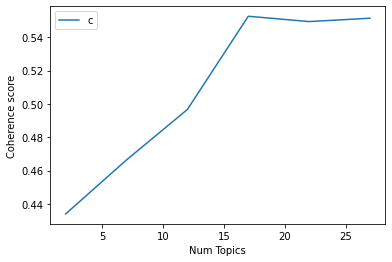

Num Topics = 2  has Coherence Value of 0.434
Num Topics = 7  has Coherence Value of 0.4664
Num Topics = 12  has Coherence Value of 0.4967
Num Topics = 17  has Coherence Value of 0.5526
Num Topics = 22  has Coherence Value of 0.5495
Num Topics = 27  has Coherence Value of 0.5515


In [ ]:
print(coherence_values)

#plotting graph
print("\n\n")

import matplotlib.pyplot as plt
start=2;stop=30;step=5
x=range(start,stop,step)

plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


#from below graph we can see coherence value almost flattens after k=15,Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics

for k, score in zip(x,coherence_values):
  print("Num Topics =", k, " has Coherence Value of", round(score, 4))

In [ ]:
#selecting best model from above, model[3] i.e.Num Topics = 17  has Coherence Value of 0.5526
optimal_model=model_list[3]
model_topics=optimal_model.show_topics()
print(model_topics)

print("\n\n",optimal_model.print_topics(num_words=10))

[(6, '0.031*"game" + 0.030*"year" + 0.027*"team" + 0.024*"play" + 0.021*"good" + 0.018*"player" + 0.017*"win" + 0.011*"season" + 0.010*"run" + 0.009*"lose"'), (9, '0.034*"window" + 0.018*"run" + 0.017*"program" + 0.014*"display" + 0.014*"application" + 0.013*"color" + 0.013*"set" + 0.013*"problem" + 0.013*"version" + 0.012*"work"'), (11, '0.011*"study" + 0.010*"drug" + 0.009*"problem" + 0.008*"find" + 0.007*"effect" + 0.007*"food" + 0.007*"case" + 0.007*"doctor" + 0.006*"patient" + 0.006*"report"'), (4, '0.032*"car" + 0.012*"bike" + 0.011*"buy" + 0.011*"power" + 0.009*"good" + 0.008*"ride" + 0.007*"engine" + 0.007*"big" + 0.007*"ground" + 0.006*"wire"'), (0, '0.045*"people" + 0.042*"make" + 0.039*"good" + 0.034*"thing" + 0.016*"give" + 0.014*"bad" + 0.013*"point" + 0.013*"love" + 0.011*"feel" + 0.011*"time"'), (5, '0.035*"file" + 0.026*"line" + 0.022*"number" + 0.020*"read" + 0.018*"follow" + 0.015*"program" + 0.011*"change" + 0.011*"output" + 0.011*"write" + 0.010*"check"'), (8, '0.02

**Finding the dominant topic in each sentence**

In [ ]:
#chcking results for one line from corpus, it gives 16 tuples as we have 16 topics and score corresponding to each.highest the score, more chances are there document belongs to that topic
print(len(optimal_model[corpus[0:1]]))
print(optimal_model[corpus[0:1]])
print(len(optimal_model[corpus[0:3]]))
print(optimal_model[corpus[0:3]])

1
[[(0, 0.04530087897227857), (1, 0.06062654947036287), (2, 0.041469461347757496), (3, 0.03508376530688905), (4, 0.13725490196078433), (5, 0.06190368867853656), (6, 0.06318082788671024), (7, 0.08106077680114192), (8, 0.04657801818045226), (9, 0.04019232213958382), (10, 0.04785515738862596), (11, 0.04913229659679964), (12, 0.03891518293141012), (13, 0.08744647284201036), (14, 0.05040943580497334), (15, 0.05040943580497334), (16, 0.06318082788671024)]]
3
[[(0, 0.04530087897227857), (1, 0.06062654947036287), (2, 0.041469461347757496), (3, 0.03508376530688905), (4, 0.13725490196078433), (5, 0.06190368867853656), (6, 0.06318082788671024), (7, 0.08106077680114192), (8, 0.04657801818045226), (9, 0.04019232213958382), (10, 0.04785515738862596), (11, 0.04913229659679964), (12, 0.03891518293141012), (13, 0.08744647284201036), (14, 0.05040943580497334), (15, 0.05040943580497334), (16, 0.06318082788671024)], [(0, 0.0338562091503268), (1, 0.05941176470588235), (2, 0.04385620915032679), (3, 0.154967

In [ ]:
def format_topic_sentence(ldamodel=lda_model , corpus=corpus,texts=data):
  df_sent_topics=pd.DataFrame()
  ldamodel_op=ldamodel[corpus] #apply lda model to corpus
  for i , row in enumerate(ldamodel_op):  #go through lda output for each document in cluster and mail topic with highest score
      row=sorted(row, key=lambda x : (x[1]), reverse=True)

      for j , (topic_num,prop_topic) in enumerate(row): #go through sorted row, and 1st index which will have topic and highest score
          if j == 0:
            wp=ldamodel.show_topic(topic_num)#getting keywords for that topic
            keywords=",".join([word for word,prop in wp])

            #append it to dataframe
            df_sent_topics=df_sent_topics.append(pd.Series([int(topic_num), round(prop_topic,4),keywords]),ignore_index=True)

          else :
            break  
   
  df_sent_topics.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'] #defining column  names of dataframe

   #original text after preprocessing is stored in data
  contents=pd.Series(texts)
   #concat above df to original df :df_sent_topics
  df_sent_topics=pd.concat([df_sent_topics,contents],axis=1)
  return df_sent_topics #return df


#call above function
df_topic_sent_kw=format_topic_sentence(ldamodel=optimal_model,corpus=corpus,texts=data)


In [ ]:
df_topic_sent_kw= df_topic_sent_kw.reset_index()
print(df_topic_sent_kw.columns,"\n\n")

#rename all columns
df_topic_sent_kw.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

Index(['index', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 0], dtype='object') 




In [ ]:
df_topic_sent_kw#looking every document in corpus and which keywords are dominant in those by LDA and dominant topic number to which they belong

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.1373,"car,bike,buy,power,good,ride,engine,big,ground...",from wheres my thing subject what car is t...
1,1,3.0,0.1550,"drive,card,problem,system,work,driver,bit,disk...",from guy kuo subject si clock poll final...
2,2,3.0,0.1462,"drive,card,problem,system,work,driver,bit,disk...",from thomas e willis subject pb questions ...
3,3,10.0,0.1049,"write,article,line,organization,host,reply,hea...",from joe green subject re weitek p ...
4,4,5.0,0.1968,"file,line,number,read,follow,program,change,ou...",from jonathan mcdowell subject re shuttle...
...,...,...,...,...,...
11309,11309,11.0,0.3352,"study,drug,problem,find,effect,food,case,docto...",from jim zisfein subject re migraines and...
11310,11310,3.0,0.1890,"drive,card,problem,system,work,driver,bit,disk...",from subject screen death mac plus line...
11311,11311,3.0,0.1745,"drive,card,problem,system,work,driver,bit,disk...",from will estes subject mounting cpu coole...
11312,11312,5.0,0.1409,"file,line,number,read,follow,program,change,ou...",from steven collins subject re sphere fro...


**Find the most representative document for each topic**

to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document

In [ ]:
top_score_topic_df=pd.DataFrame()
top_score_groupby=df_topic_sent_kw.groupby('Dominant_Topic')

for i , grp in top_score_groupby:
      top_score_topic_df = pd.concat([top_score_topic_df,grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(1)],axis=0)

#reset index
top_score_topic_df.reset_index(drop=True, inplace=True)

#Format
top_score_topic_df.columns = ['Document_No','Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

top_score_topic_df

,Document_No,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,3902,0.0,0.4409,"people,make,good,thing,give,bad,point,love,fee...",from brian ceccarelli subject ...
1,3864,1.0,0.6065,"mail,information,include,send,list,post,addres...",from nick c fotis subject apr com...
2,4498,2.0,0.8869,"key,system,encryption,technology,chip,bit,phon...",from jim gillogly subject clipper chip and...
3,7499,3.0,0.7372,"drive,card,problem,system,work,driver,bit,disk...",from d keith rice subject re drive contr...
4,2339,4.0,0.6802,"car,bike,buy,power,good,ride,engine,big,ground...",from subject grounding power wiring was re ...
5,1704,5.0,0.9625,"file,line,number,read,follow,program,change,ou...",from landon c noll subject reposting t...
6,8642,6.0,0.7140,"game,year,team,play,good,player,win,season,run...",from bryan k strouse subject nhl results f...
7,6459,7.0,0.4927,"time,back,start,leave,happen,day,fire,hear,put...",from james foster x subject re my gun...
8,6539,8.0,0.5829,"state,gun,law,government,people,kill,case,isra...",from center for policy research subject fina...
9,4614,9.0,0.6923,"window,run,program,display,application,color,s...",from david b lewis subject comp windows x...


**Topic distribution across documents**

In [ ]:
print("\n# Number of Documents for Each Topic\n")
topic_counts=df_topic_sent_kw['Dominant_Topic'].value_counts()
print(topic_counts)


print("\n\n# percentage of documents for each topic\n")
topic_percentage=round(topic_counts/topic_counts.sum() , 4)*100
print(topic_percentage)


# Number of Documents for Each Topic

3.0     1514
4.0     1112
6.0     1035
9.0      913
12.0     891
8.0      773
1.0      645
10.0     632
11.0     592
14.0     588
2.0      511
7.0      420
13.0     392
15.0     383
0.0      370
16.0     354
5.0      189
Name: Dominant_Topic, dtype: int64


# percentage of documents for each topic

3.0     13.38
4.0      9.83
6.0      9.15
9.0      8.07
12.0     7.88
8.0      6.83
1.0      5.70
10.0     5.59
11.0     5.23
14.0     5.20
2.0      4.52
7.0      3.71
13.0     3.46
15.0     3.39
0.0      3.27
16.0     3.13
5.0      1.67
Name: Dominant_Topic, dtype: float64
